In [1]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import importlib

sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config
from analysis import Normalizer, train_test_split, get_dataloaders, calculate_auc, ClassifyDataset, predict, Bootstrap_Permutation

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [2]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

model_hyper_parameters = load_toml_config("Transformer")
output_dim = model_hyper_parameters["output_dim"]

# Load embedding points

In [3]:
import h5py

database_path = "/home/desmondhe/ADwithNE/latent"
output_dim = [4,8,16,32]
embedding_points_file_name = {}
embedding_points_file = {}
embedding_points = {}
targets = {}
for dim in output_dim:
    embedding_points_file_name[dim] = "embedding_points_dim{}.h5".format(dim)
    embedding_points_file[dim] = os.path.join(database_path, embedding_points_file_name[dim])
    embedding_points[dim] = h5py.File(embedding_points_file[dim])
bsm_events = ['charged_Higgs', 'leptoquark', 'neutral_Higgs', 'neutral_boson']

In [4]:
from analysis import Normalizer

# Split embed points

In [5]:
from analysis import train_test_split, get_dataloaders

In [6]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0.5
n = 200000

test_dimension = 32
normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])

selected_idx = np.random.choice(len(embedding_points[test_dimension]['SM']), 2 * n, replace=False)
exp_events = np.array(embedding_points[test_dimension]['SM'])[selected_idx[:n]]
bkg_events = np.array(embedding_points[test_dimension]['SM'])[selected_idx[n:]]
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=256)

# Classify Model

In [7]:
from model import MLP
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(test_dimension, hidden_sizes=hidden_dim)

# Train

In [8]:
from metrics import BinaryACCUpdater

In [9]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [10]:
from classify import train_model

In [11]:
# opt_train_model  = torch.compile(train_model)

In [12]:
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=5000, val_batch_size=5000, num_workers=16, prefetch_factor=16)

In [13]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-11-09 13:08:29
Epoch 1 / 50

100%|██████████| 13/13 [00:00<00:00, 35.74it/s, val_Accuracy=0.501, val_loss=0.693]
<<<<<< reach best val_Accuracy : 0.5010423064231873 >>>>>>

================================================================================2024-11-09 13:08:31
Epoch 2 / 50

100%|██████████| 13/13 [00:00<00:00, 38.22it/s, val_Accuracy=0.502, val_loss=0.693]
<<<<<< reach best val_Accuracy : 0.5020307302474976 >>>>>>

================================================================================2024-11-09 13:08:33
Epoch 3 / 50

100%|██████████| 13/13 [00:00<00:00, 37.39it/s, val_Accuracy=0.498, val_loss=0.693]

================================================================================2024-11-09 13:08:34
Epoch 4 / 50

100%|██████████| 13/13 [00:00<00:00, 36.73it/s, val_Accuracy=0.499, val_loss=0.693]

================================================================================2024-

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.693350,0.501650,0.693193,0.501042,1
1,0.693208,0.500035,0.693148,0.502031,2
2,0.693187,0.499892,0.693191,0.497812,3
3,0.693166,0.501427,0.693179,0.498788,4
4,0.693165,0.501296,0.693073,0.506096,5
5,0.693158,0.500981,0.693259,0.494977,6
6,0.693188,0.499669,0.693049,0.506704,7
7,0.693174,0.500846,0.693047,0.506988,8
8,0.693166,0.501581,0.693306,0.495754,9
9,0.693164,0.501304,0.693216,0.498038,10


# Test statistics

In [14]:
from analysis import h_hat, Bootstrap_Permutation

In [16]:
%timeit selected_idx = np.random.choice(len(embedding_points[test_dimension]['SM']), 2 * n, replace=False)

324 ms ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
hypothesis_dict = load_toml_config("hypothesis_test")
n = hypothesis_dict["n"]
n_null = hypothesis_dict["n_null"]

In [18]:
auc_results = np.zeros(n_null)
lrt_results = np.zeros(n_null)
mce_results = np.zeros(n_null)
for i in tqdm(range(n_null)):
    selected_idx = np.random.choice(len(embedding_points[test_dimension]['SM']), 2 * n, replace=False)
    exp_events = np.array(embedding_points[test_dimension]['SM'])[selected_idx[:n]]
    bkg_events = np.array(embedding_points[test_dimension]['SM'])[selected_idx[n:]]
    X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
    n1 = len(W1)
    m1 = len(X1)
    n2 = len(W2)
    m2 = len(X2)
    normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])
    train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=5000, val_batch_size=5000, num_workers=16, prefetch_factor=16)

    hidden_dim = [8, 16, 16, 16, 8]
    naive_model = MLP(test_dimension, hidden_sizes=hidden_dim)
    naive_model.to(device)
    optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.BCELoss()
    acc_metric = BinaryACCUpdater()
    metric_dict = {"Accuracy": acc_metric}

    train_model(  
        naive_model, optimizer,
        loss_fn, metrics_dict=metric_dict,
        train_dataloader=train_dataloader, val_dataloader=val_dataloader,
        monitor="val_Accuracy", mode="max",
        epochs=50,
        verbose=False
        )
    bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)
    auc_results[i] = bootstrap_permutation.auc_exp
    lrt_results[i] = bootstrap_permutation.lrt_exp
    mce_results[i] = bootstrap_permutation.mce_exp

  9%|▉         | 176/2000 [1:30:10<17:18:37, 34.17s/it]

: 

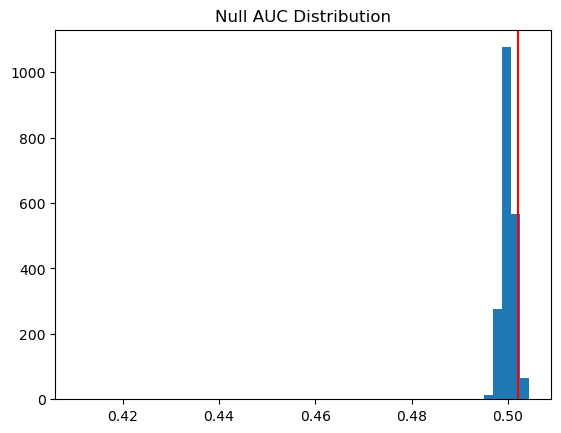

In [ ]:
plt.hist(auc_results, bins=50, edgecolor='black')
threshold = np.percentile(auc_results, 95)
plt.axvline(threshold, color='r')
plt.title("Null AUC Distribution")
plt.show()

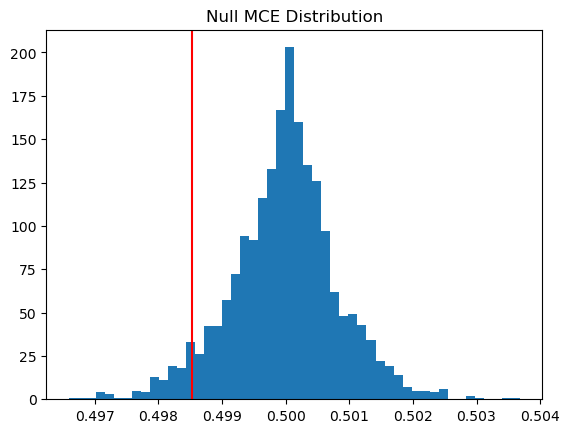

In [ ]:
plt.hist(mce_results, bins=50, edgecolor='black')
threshold = np.percentile(mce_results, 5)
plt.axvline(threshold, color='r')
plt.title("Null MCE Distribution")
plt.show()

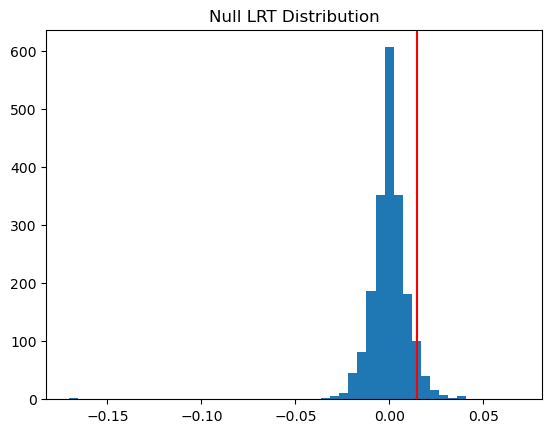

In [ ]:
plt.hist(lrt_results, bins=50, edgecolor='black')
threshold = np.percentile(lrt_results, 95)
plt.axvline(threshold, color='r')
plt.title("Null LRT Distribution")
plt.show()

In [23]:
# Find threshold for 95% confidence level
lrt_threshold = np.percentile(lrt_results, 95)
print(lrt_threshold)

# Find threshold for 95% confidence level
mce_threshold = np.percentile(mce_results, 5)
print(mce_threshold)

# Find threshold for 95% confidence level
auc_threshold = np.percentile(auc_results, 95)
print(auc_threshold)

0.014815863868755264
0.49852925000000003
0.50212982325


In [24]:
import toml
toml_file = '../config.toml'
with open(toml_file, 'r') as f:
    config = toml.load(f)
 
config['threshold']['lrt'] = float(lrt_threshold)
config['threshold']['mce'] = float(mce_threshold)
config['threshold']['auc'] = float(auc_threshold)
with open(toml_file, 'w') as f:
    toml.dump(config, f)